In [ ]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import joblib
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

In [ ]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json




In [ ]:
!kaggle datasets download -d obulisainaren/multi-cancer

!unzip multi-cancer.zip -d /content/multi-cancer



Dataset URL: https://www.kaggle.com/datasets/obulisainaren/multi-cancer
License(s): CC-BY-NC-SA-4.0
multi-cancer.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  multi-cancer.zip
replace /content/multi-cancer/Multi Cancer/Multi Cancer/ALL/all_benign/all_benign_0001.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
data_dir = "/content/multi-cancer/Multi Cancer/Multi Cancer"

target_folder='ALL'
filepath=[]
labels=[]
all_folder_path = os.path.join(data_dir, target_folder)

if os.path.isdir(all_folder_path):
    filelist = os.listdir(all_folder_path)
    for f in filelist:
        fpath = os.path.join(all_folder_path, f)
        fipath=os.listdir(fpath)
        for image in fipath:
            path = os.path.join(fpath, image)
            filepath.append(path)
            labels.append(f)

f_series = pd.Series(filepath, name='filepath')
l_series = pd.Series(labels, name='labels')
df = pd.concat([f_series, l_series], axis=1)

In [ ]:
df.head()

,filepath,labels
0,/content/multi-cancer/Multi Cancer/Multi Cance...,all_pro
1,/content/multi-cancer/Multi Cancer/Multi Cance...,all_pro
2,/content/multi-cancer/Multi Cancer/Multi Cance...,all_pro
3,/content/multi-cancer/Multi Cancer/Multi Cance...,all_pro
4,/content/multi-cancer/Multi Cancer/Multi Cance...,all_pro


In [ ]:
count=df['labels'].value_counts().reset_index()
count.columns=['labels','count']
count_fig=px.bar(count,x='labels',y='count',title='count of labels',text_auto=True)
count_fig.show()

In [ ]:
strat=df['labels']
train_df ,dummy_df=train_test_split(df,test_size=0.3,random_state=42,stratify=strat)
strate=dummy_df['labels']
valid_df,test_df=train_test_split(dummy_df,test_size=0.5,random_state=42,stratify=strate)

In [ ]:
print(train_df.shape)
print(valid_df.shape)
print(test_df.shape)

(14000, 2)
(3000, 2)
(3000, 2)


In [ ]:
count_train=train_df['labels'].value_counts().reset_index()
count_train.columns=['labels','count']
count=px.bar(count_train,x='labels',y='count',title='count of labels per train_df',text_auto=True)
count.show()

In [ ]:
count_valid=valid_df['labels'].value_counts().reset_index()
count_valid.columns=['labels','count']
fig=px.bar(count_valid,x='labels',y='count',title='count of labels per valid_df',text_auto=True)
fig.show()

In [ ]:
count_test=test_df['labels'].value_counts().reset_index()
count_test.columns=['labels','count']
fig=px.bar(count_test,x='labels',y='count',title='count of labels per test_df',text_auto=True)
fig.show()

In [ ]:
batch_size = 64
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe(train_df, x_col= 'filepath', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe(valid_df, x_col= 'filepath', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= 'rgb', shuffle= True, batch_size= batch_size)

test_gen = ts_gen.flow_from_dataframe(test_df, x_col= 'filepath', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= batch_size)

Found 14000 validated image filenames belonging to 4 classes.
Found 3000 validated image filenames belonging to 4 classes.
Found 3000 validated image filenames belonging to 4 classes.


In [ ]:
batch_size = 64
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe(train_df, x_col= 'filepath', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe(valid_df, x_col= 'filepath', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= 'rgb', shuffle= True, batch_size= batch_size)

test_gen = ts_gen.flow_from_dataframe(test_df, x_col= 'filepath', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= batch_size)

Found 14000 validated image filenames belonging to 4 classes.
Found 3000 validated image filenames belonging to 4 classes.
Found 3000 validated image filenames belonging to 4 classes.


In [ ]:
base_model=keras.applications.EfficientNetB0(include_top=False,
    weights="imagenet",
    input_shape=(224,224,3))
model=Sequential([
    base_model,
    Flatten(),
    Dense(256,activation='relu'),
    Dropout(0.25),
    Dense(64,activation='relu'),
    Dense(4,activation='softmax')
])
model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

In [53]:
early_stopping = EarlyStopping(monitor='val_loss',patience=5,restore_best_weights=True)
history=model.fit(train_gen,epochs=10,validation_data=valid_gen,shuffle=False,
                  callbacks=[early_stopping])

Epoch 1/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 172s 480ms/step - accuracy: 0.9484 - loss: 0.1692 - val_accuracy: 0.9960 - val_loss: 0.0153
Epoch 2/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 66s 300ms/step - accuracy: 0.9990 - loss: 0.0051 - val_accuracy: 1.0000 - val_loss: 1.1676e-05
Epoch 3/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 64s 293ms/step - accuracy: 0.9989 - loss: 0.0028 - val_accuracy: 1.0000 - val_loss: 1.0904e-05
Epoch 4/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 64s 291ms/step - accuracy: 0.9989 - loss: 0.0044 - val_accuracy: 0.9997 - val_loss: 9.2035e-04
Epoch 5/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 65s 294ms/step - accuracy: 0.9998 - loss: 9.2003e-04 - val_accuracy: 1.0000 - val_loss: 1.3435e-06
Epoch 6/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 64s 293ms/step - accuracy: 1.0000 - loss: 4.9816e-04 - val_accuracy: 0.9997 - val_loss: 3.5872e-04
Epoch 7/100
219/219 ━━━━━━━━━━━━━━━━━━━━ 64s 293ms/step - accuracy: 0.9998 - loss: 8.0799e-04 - val_accuracy: 1.0000 - val_loss: 3.4770e-05
Epoch 8/100
219/219 ━━━━━━━━━━━━━━━━━━━

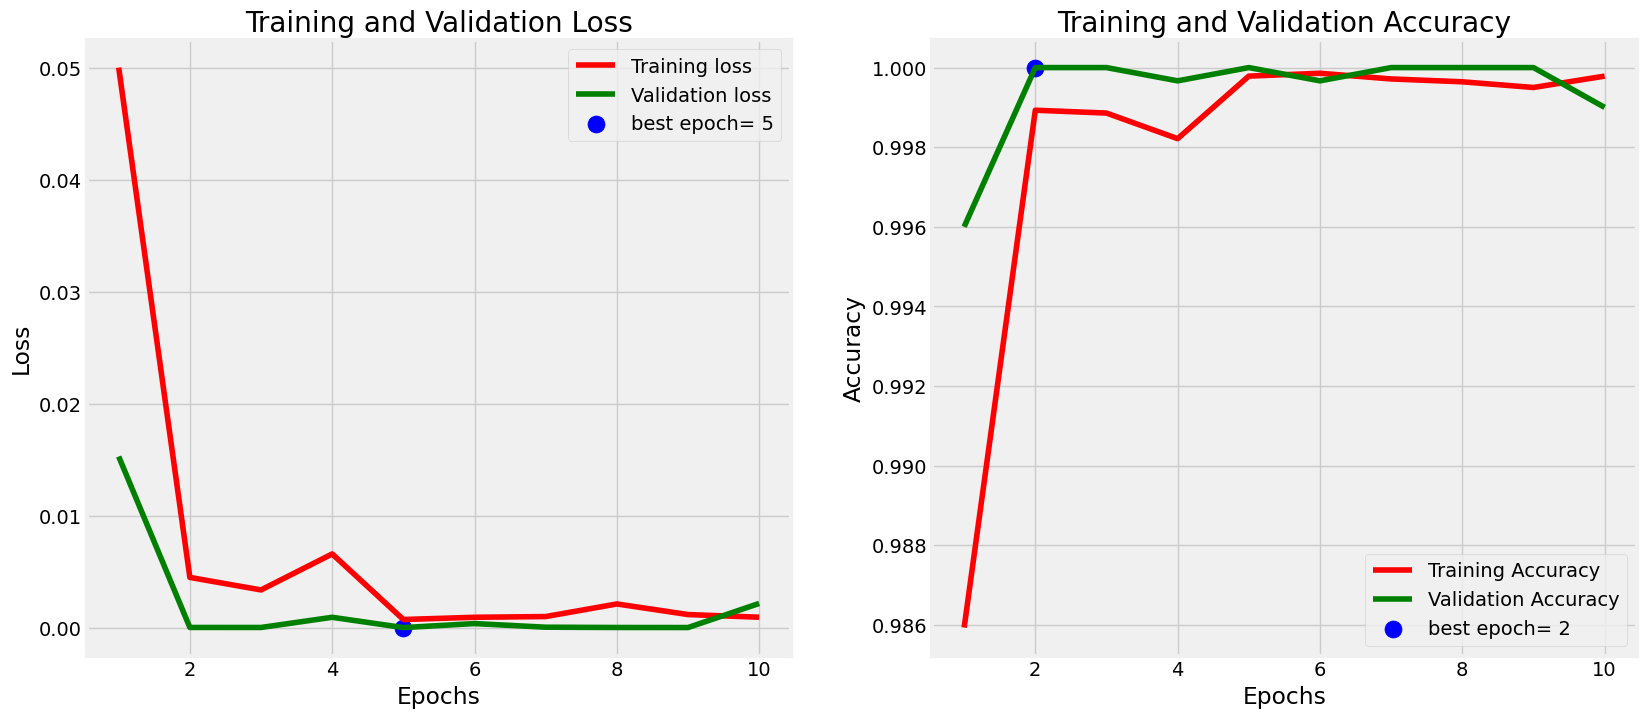

In [54]:
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')
plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [55]:
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Valid Loss: ", valid_score[0])
print("Valid Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

40/40 ━━━━━━━━━━━━━━━━━━━━ 9s 233ms/step - accuracy: 1.0000 - loss: 1.1755e-06
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 183ms/step - accuracy: 1.0000 - loss: 9.1466e-07
40/40 ━━━━━━━━━━━━━━━━━━━━ 9s 222ms/step - accuracy: 1.0000 - loss: 3.2034e-06
Train Loss:  1.1542831543920329e-06
Train Accuracy:  1.0
--------------------
Valid Loss:  1.2368639090709621e-06
Valid Accuracy:  1.0
--------------------
Test Loss:  4.003248250228353e-06
Test Accuracy:  1.0


In [57]:
preds = model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)

47/47 ━━━━━━━━━━━━━━━━━━━━ 9s 196ms/step


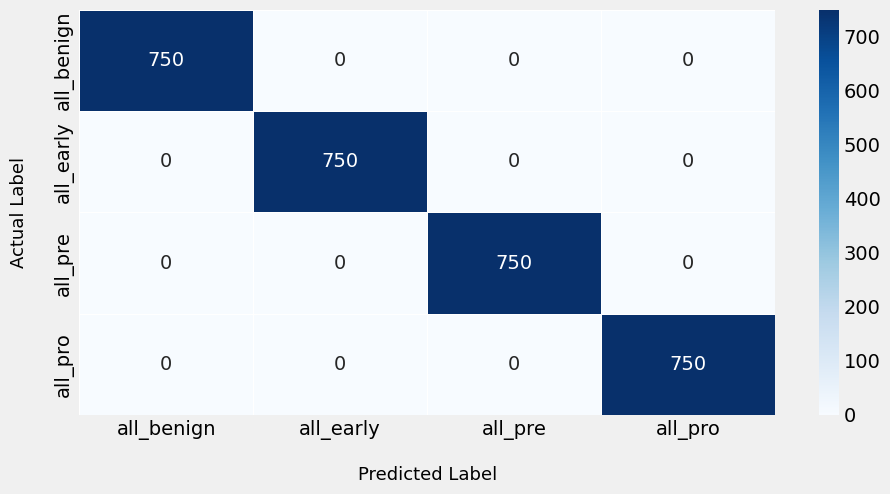

In [58]:
plt.figure(figsize=(10,5))
cm=confusion_matrix(test_gen.classes,y_pred)
labels = list(test_gen.class_indices.keys())
sns.heatmap(cm,annot=True,fmt="d",xticklabels=labels,yticklabels=labels,cmap="Blues", linewidths=.5)
plt.xlabel('\nPredicted Label',fontsize=13)
plt.ylabel('Actual Label\n',fontsize=13);

In [61]:
g_dict = train_gen.class_indices
classes = list(g_dict.keys())  # Define the classes
print(classification_report(test_gen.classes, y_pred, target_names=classes))


              precision    recall  f1-score   support

  all_benign       1.00      1.00      1.00       750
   all_early       1.00      1.00      1.00       750
     all_pre       1.00      1.00      1.00       750
     all_pro       1.00      1.00      1.00       750

    accuracy                           1.00      3000
   macro avg       1.00      1.00      1.00      3000
weighted avg       1.00      1.00      1.00      3000



2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 65ms/step


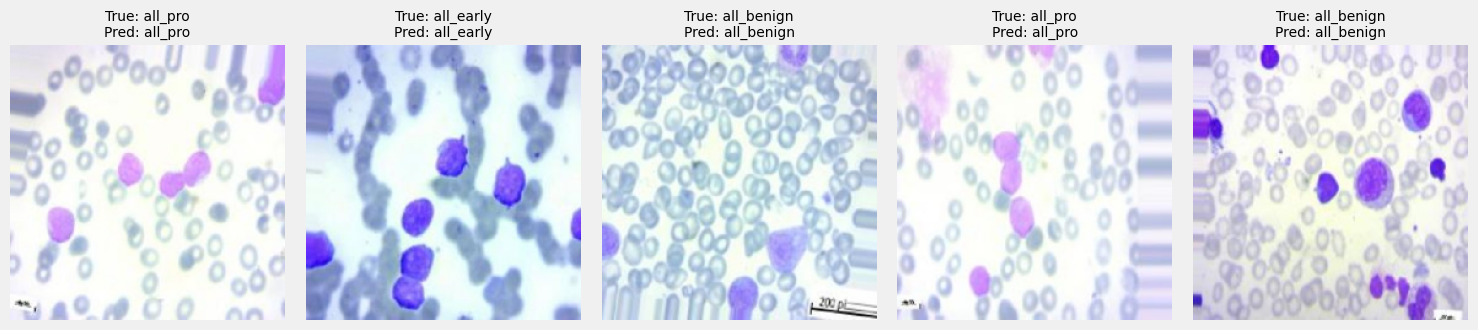

In [62]:

# Get a batch of 5 test images and their corresponding true labels
images, true_labels = next(test_gen)

# Predict the labels for these images
predictions = model.predict(images)
predicted_labels = np.argmax(predictions, axis=1)

# Get the class names from the generator
classes = list(test_gen.class_indices.keys())

# Visualize the images with their corresponding true and predicted labels
plt.figure(figsize=(15, 15))

for i in range(5):
    plt.subplot(1, 5, i + 1)
    image = images[i] / 255.0  # Normalize the image
    plt.imshow(image)
    true_label = np.argmax(true_labels[i])  # True label
    predicted_label = predicted_labels[i]  # Predicted label

    plt.title(f'True: {classes[true_label]}\nPred: {classes[predicted_label]}', fontsize=10)
    plt.axis('off')

plt.tight_layout()
plt.show()
